In [1]:
import pybaseball as pyb
import pandas as pd
import numpy as npimport
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


Read in the data.

In [2]:
df = pd.read_csv('processed_mvp_data.csv')
df_2025 = pd.read_csv('processed_2025_data.csv')

Now we can move on to our final cleaning stage.

In [3]:
# Drop any rows where a league couldn't be assigned (e.g., for traded players)
df.dropna(subset=['League'], inplace=True)
df_2025.dropna(subset=['League'], inplace=True)
# For simplicity in this stage, fill any remaining numeric NaNs with 0
# (A more advanced step could be mean/median imputation)
df.fillna(0, inplace=True)
df_2025.fillna(0, inplace=True)

# --- Split by League ---
al_df = df[df['League'] == 'AL'].copy()
nl_df = df[df['League'] == 'NL'].copy()

al_df_2025 = df_2025[df_2025['League'] == 'AL'].copy()
nl_df_2025 = df_2025[df_2025['League'] == 'NL'].copy()

# --- Time-Based Split for the American League ---
# We'll use the AL for this example. Repeat these steps for the NL.
train_df = al_df[al_df['Season'] <= 2020]
test_df = al_df[al_df['Season'] > 2020]

# --- NL: Time-Based Split ---
train_df_nl = nl_df[nl_df['Season'] <= 2020]
test_df_nl = nl_df[nl_df['Season'] > 2020]

# --- Separate Features (X) and Target (y) ---
# Define the target variable
target = 'MVP'
# Define identifiers and other columns to drop from the feature set
to_drop = ['IDfg', 'Season', 'Name', 'Team', 'League', 'MVP']
feature_columns = [col for col in al_df.columns if col not in to_drop]

X_train = train_df[feature_columns]
y_train = train_df[target]
X_test = test_df[feature_columns]
y_test = test_df[target]

# --- NL: Separate Features (X) and Target (y) ---
X_train_nl = train_df_nl[feature_columns]
y_train_nl = train_df_nl[target]
X_test_nl = test_df_nl[feature_columns]
y_test_nl = test_df_nl[target]

Here we look to train a discovery model to find which features are "best".

In [4]:
# --- Handle Class Imbalance for XGBoost ---
# XGBoost uses a parameter called 'scale_pos_weight'.
# The standard formula is: count(negative class) / count(positive class)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# --- NL: Handle Class Imbalance ---
scale_pos_weight_nl = y_train_nl.value_counts()[0] / y_train_nl.value_counts()[1]


# --- Train the XGBoost Model ---
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False, # Add this to avoid a deprecation warning
    eval_metric='logloss',   # Add this to avoid a deprecation warning
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- NL: Train the XGBoost Model ---
xgb_model_nl = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_nl,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model_nl.fit(X_train_nl, y_train_nl)

/var/folders/pz/pxdv_rx91j70b52l206jy3qr0000gn/T/ipykernel_36905/3128543253.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
/var/folders/pz/pxdv_rx91j70b52l206jy3qr0000gn/T/ipykernel_36905/3128543253.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight_nl = y_train_nl.value_counts()[0] / y_train_nl.value_counts()[1]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:05:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [5]:
predictions_xgb = xgb_model.predict(X_test)

print("\n--- XGBoost Model Evaluation (American League) ---")
print(classification_report(y_test, predictions_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_xgb))


--- XGBoost Model Evaluation (American League) ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2595
        True       0.60      0.75      0.67         4

    accuracy                           1.00      2599
   macro avg       0.80      0.87      0.83      2599
weighted avg       1.00      1.00      1.00      2599

Confusion Matrix:
[[2593    2]
 [   1    3]]


In [6]:
# --- NL: Evaluate the Model ---
predictions_xgb_nl = xgb_model_nl.predict(X_test_nl)
print("\n\n--- XGBoost Model Evaluation (National League) ---")
print(classification_report(y_test_nl, predictions_xgb_nl))
print("Confusion Matrix:")
print(confusion_matrix(y_test_nl, predictions_xgb_nl))




--- XGBoost Model Evaluation (National League) ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2644
        True       0.18      0.67      0.29         3

    accuracy                           1.00      2647
   macro avg       0.59      0.83      0.64      2647
weighted avg       1.00      1.00      1.00      2647

Confusion Matrix:
[[2635    9]
 [   1    2]]


In [7]:
# --- Prepare the 2025 Data for Prediction ---
# We use the same 'feature_columns' list from our training setup to ensure the model sees the exact same features
X_al_2025 = al_df_2025[feature_columns]

# --- Generate Prediction Probabilities ---
# predict_proba returns probabilities for [False, True]. We want the second column, which is the probability of True (is an MVP).
mvp_probabilities_al = xgb_model.predict_proba(X_al_2025)[:, 1]

# --- Create the AL MVP Ladder ---
al_df_2025['MVP_Probability'] = mvp_probabilities_al

# Sort by the highest probability to see the top candidates
mvp_ladder_al = al_df_2025.sort_values(by='MVP_Probability', ascending=False)

# --- Display the Top 10 AL MVP Candidates ---
# Note: Since the season is still in progress, these are projections!
print(f"--- AL MVP Ladder (Live Projection as of September 25, 2025) ---")
display_cols = ['Name', 'Team', 'WAR', 'wRC+', 'OPS', 'MVP_Probability']
print(mvp_ladder_al[display_cols].head(10))

--- AL MVP Ladder (Live Projection as of September 25, 2025) ---
                 Name Team  WAR   wRC+    OPS  MVP_Probability
47        Aaron Judge  NYY  9.2  199.0  1.121         0.856362
116       Cal Raleigh  SEA  8.8  160.0  0.945         0.645216
38       Byron Buxton  MIN  4.7  133.0  0.863         0.011242
124      Tarik Skubal  DET  6.6    0.0  0.000         0.000752
143    Bobby Witt Jr.  KCR  7.8  130.0  0.853         0.000321
24    George Springer  TOR  4.8  163.0  0.947         0.000314
170   Junior Caminero  TBR  4.2  126.0  0.838         0.000265
133   Julio Rodriguez  SEA  5.5  126.0  0.796         0.000220
137      Jarren Duran  BOS  3.8  112.0  0.779         0.000152
152  Gunnar Henderson  BAL  4.6  119.0  0.786         0.000122


In [8]:
# --- NL: Predict the 2025 MVP ---
X_nl_2025 = nl_df_2025[feature_columns]
mvp_probabilities_nl = xgb_model_nl.predict_proba(X_nl_2025)[:, 1]
nl_df_2025['MVP_Probability'] = mvp_probabilities_nl
mvp_ladder_nl = nl_df_2025.sort_values(by='MVP_Probability', ascending=False)

# --- Display the Top 10 NL MVP Candidates ---
print(f"\n--- NL MVP Ladder (Live Projection as of September 25, 2025) ---")
print(mvp_ladder_nl[display_cols].head(10))


--- NL MVP Ladder (Live Projection as of September 25, 2025) ---
                    Name Team  WAR   wRC+    OPS  MVP_Probability
95         Shohei Ohtani  LAD  7.2  171.0  1.011         0.998334
146       Corbin Carroll  ARI  6.4  139.0  0.886         0.091812
55        Kyle Schwarber  PHI  4.8  152.0  0.929         0.000514
100            Juan Soto  NYM  5.8  158.0  0.932         0.000476
172           James Wood  WSN  3.1  125.0  0.816         0.000385
81           Pete Alonso  NYM  3.5  141.0  0.872         0.000165
168  Pete Crow-Armstrong  CHC  5.1  107.0  0.762         0.000164
41            Matt Olson  ATL  4.7  137.0  0.854         0.000125
118           Oneil Cruz  PIT  1.7   89.0  0.687         0.000109
94    Fernando Tatis Jr.  SDP  5.7  129.0  0.805         0.000080


**Now let's visualize our predictions!**

/var/folders/pz/pxdv_rx91j70b52l206jy3qr0000gn/T/ipykernel_36905/2324830595.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MVP_Probability', y='Name', data=al_ladder_to_plot, palette='rocket')


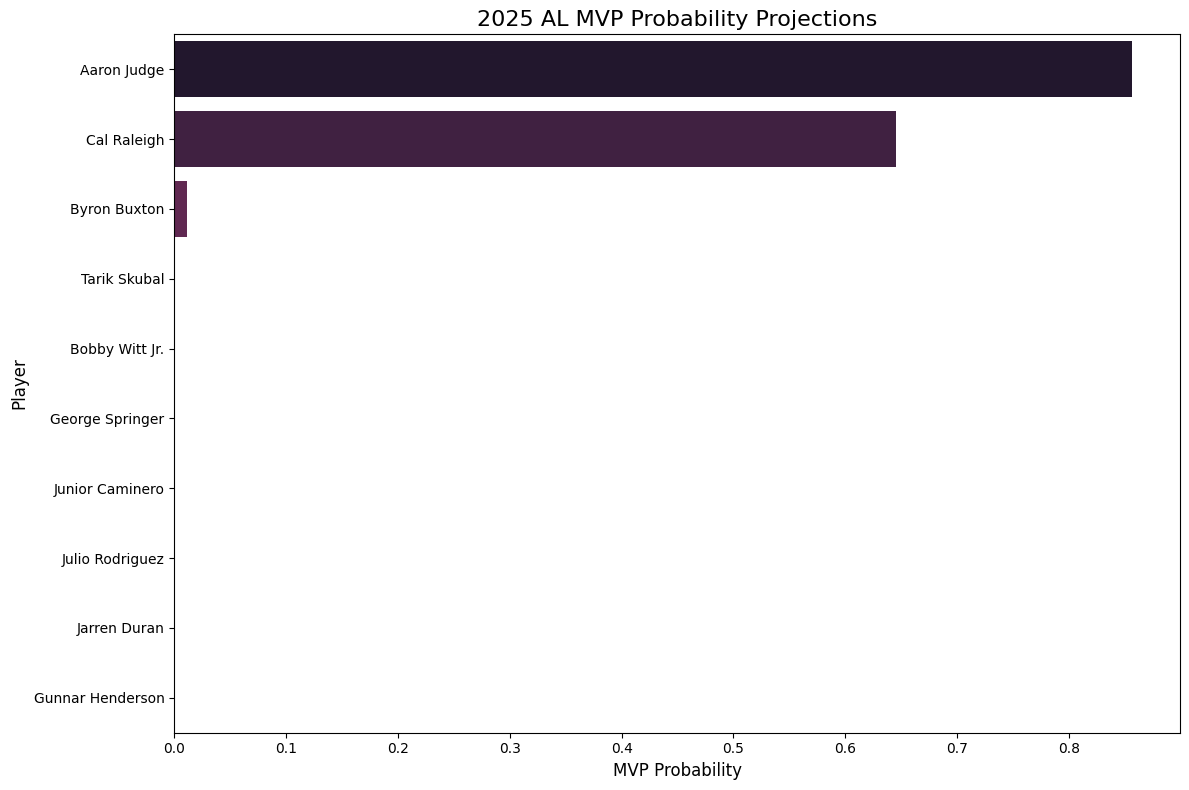

In [9]:
# --- Visualize the American League MVP Ladder ---
al_ladder_to_plot = mvp_ladder_al.head(10)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='MVP_Probability', y='Name', data=al_ladder_to_plot, palette='rocket')

# Add titles and labels for clarity
plt.title('2025 AL MVP Probability Projections', fontsize=16)
plt.xlabel('MVP Probability', fontsize=12)
plt.ylabel('Player', fontsize=12)

# Ensure everything fits and save the figure
plt.tight_layout()

/var/folders/pz/pxdv_rx91j70b52l206jy3qr0000gn/T/ipykernel_36905/460663867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MVP_Probability', y='Name', data=nl_ladder_to_plot, palette='viridis')


Text(0, 0.5, 'Player')

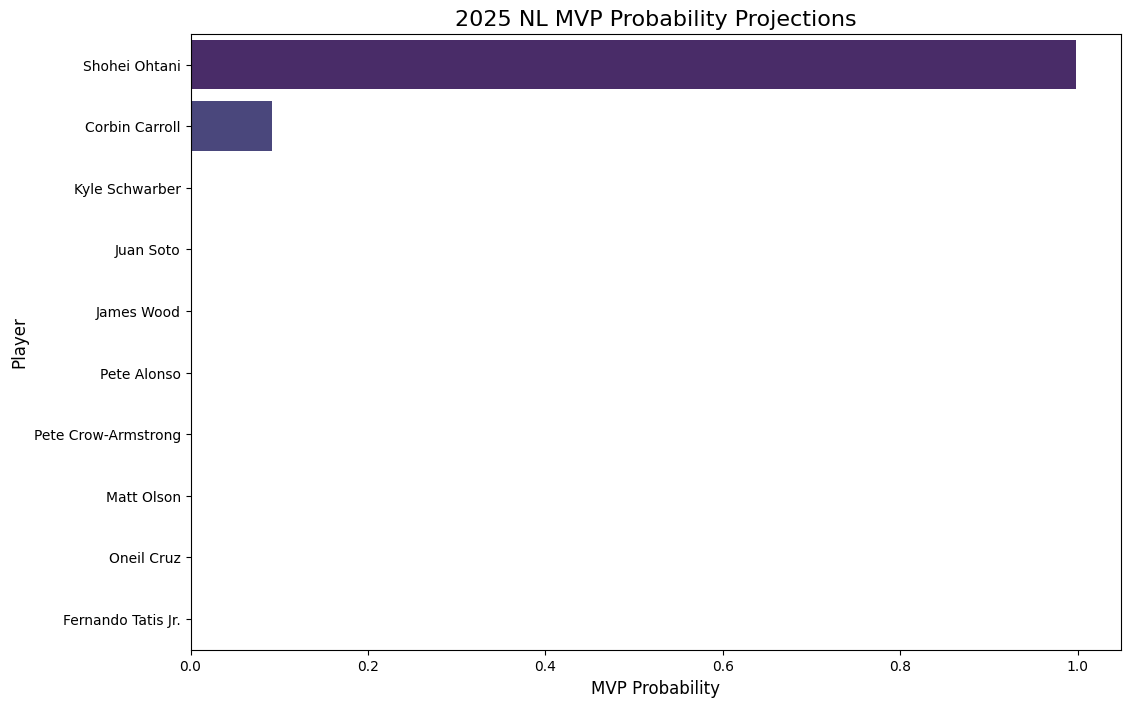

In [10]:
# --- Visualize the National League MVP Ladder ---

# Select the top 10 candidates for a clean chart
nl_ladder_to_plot = mvp_ladder_nl.head(10)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='MVP_Probability', y='Name', data=nl_ladder_to_plot, palette='viridis')

# Add titles and labels for clarity
plt.title('2025 NL MVP Probability Projections', fontsize=16)
plt.xlabel('MVP Probability', fontsize=12)
plt.ylabel('Player', fontsize=12)
